## 1. Melbourne-bike-shop 

#### Import libraries

In [1]:

import numpy as np # library to handle data in a vectorized manner
import matplotlib.pyplot as plt # plotting library
import seaborn as sns
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors


# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print('Libraries imported.')

Libraries imported.


#### Get Melbourne corodinates

In [2]:
address = 'Officer VIC 3127, Australia'

geolocator = Nominatim(user_agent="mel_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Melbourne are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Melbourne are -38.049175, 145.41180221332.


### get and scrap data from wikipedia ( create a dataframe )

In [3]:
url='https://en.wikipedia.org/wiki/Local_government_areas_of_Victoria#Greater_Melbourne'
df=pd.read_html(url, attrs={"class": "wikitable"})
df=df[0]

In [4]:
df.columns

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], dtype='int64')

In [5]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,Local government area,Council seat,Region,Year est.,Land area,Population(2001 census),Population(2016 census),Councillors(2012),Notes,Map,NaN,NaN
1,km²,sq mi,Density(2016),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,City of Melbourne,Melbourne,Inner Melbourne,12 August 1842,37,14,3486,"60,745[1]","135,959[2]",11,Capital city of Victoria.,NaN
3,City of Port Phillip,St Kilda,Inner Melbourne,22 June 1994,21,8,5101,"78,227[3]","100,863[4]",7,"Amalgamation of the cities of St Kilda, South ...",NaN
4,City of Stonnington,Malvern,Inner Melbourne,22 June 1994,26,10,4152,"86,090[5]","103,832[6]",9,Amalgamation of the cities of Malvern and Prahran,NaN


In [6]:
df=df[[0,1,2]]
df=df.drop(df.index[1])
df.head()

,0,1,2
0,Local government area,Council seat,Region
2,City of Melbourne,Melbourne,Inner Melbourne
3,City of Port Phillip,St Kilda,Inner Melbourne
4,City of Stonnington,Malvern,Inner Melbourne
5,City of Yarra,Richmond,Inner Melbourne


In [7]:
df[['Local government area','Council','Region']]=df[[0,1,2]]

df.head()

,0,1,2,Local government area,Council,Region
0,Local government area,Council seat,Region,Local government area,Council seat,Region
2,City of Melbourne,Melbourne,Inner Melbourne,City of Melbourne,Melbourne,Inner Melbourne
3,City of Port Phillip,St Kilda,Inner Melbourne,City of Port Phillip,St Kilda,Inner Melbourne
4,City of Stonnington,Malvern,Inner Melbourne,City of Stonnington,Malvern,Inner Melbourne
5,City of Yarra,Richmond,Inner Melbourne,City of Yarra,Richmond,Inner Melbourne


In [8]:
df=df.drop([0,1,2], axis=1)
df=df.drop(df.index[0])
df=df.reset_index(drop= True)

In [9]:
df['Neighborhood']=df['Council']+',vic,australia'

In [10]:
df.head()

,Local government area,Council,Region,Neighborhood
0,City of Melbourne,Melbourne,Inner Melbourne,"Melbourne,vic,australia"
1,City of Port Phillip,St Kilda,Inner Melbourne,"St Kilda,vic,australia"
2,City of Stonnington,Malvern,Inner Melbourne,"Malvern,vic,australia"
3,City of Yarra,Richmond,Inner Melbourne,"Richmond,vic,australia"
4,City of Banyule,Ivanhoe,Metropolitan Melbourne,"Ivanhoe,vic,australia"


### Get corodinates for all neighboorhoods

In [11]:
geolocator = Nominatim(user_agent="mel", timeout=5)
df['points'] = df['Neighborhood'].apply(geolocator.geocode)

In [12]:
df["Latitude"]=df["points"].apply(lambda x: x.latitude if x != None else None)
df["Longitude"]=df["points"].apply(lambda x: x.longitude if x != None else None)



In [13]:
df.columns

Index(['Local government area', 'Council', 'Region', 'Neighborhood', 'points',
       'Latitude', 'Longitude'],
      dtype='object')

#### Creating a data from for all corodinates

In [14]:
mel_subs=(df[['Neighborhood','Latitude','Longitude']])
mel_subs=mel_subs.sort_values(['Neighborhood'], ascending=[True])
mel_subs=mel_subs.reset_index(drop= True)
mel_subs.head()

,Neighborhood,Latitude,Longitude
0,"Altona,vic,australia",-37.883608,144.758616
1,"Broadmeadows,vic,australia",-37.673105,144.940159
2,"Camberwell,vic,australia",-37.838462,145.074077
3,"Caulfield North,vic,australia",-37.870828,145.021801
4,"Cheltenham,vic,australia",-37.963418,145.061567


#### Get neighborhood statistics are  from Australian Bureau of Statistics
and created spreadsheet
https://quickstats.censusdata.abs.gov.au/census_services/getproduct/census/2016/quickstat/208021177?opendocument

In [15]:
pop_nei=pd.read_csv('stats.csv')
pop_nei.head()

,Neighborhood,population,median age,yealy income
0,"Altona,vic,australia",12689,42,74880
1,"Broadmeadows,vic,australia",13305,31,47476
2,"Camberwell,vic,australia",21400,41,115024
3,"Caulfield North,vic,australia",20967,34,99944
4,"Cheltenham,vic,australia",22291,40,78104


### add the statistics with corodinate data

In [16]:
pop_nei['Latitude']=mel_subs['Latitude']
pop_nei['Longitude']=mel_subs['Longitude']
pop_nei=pop_nei[['Neighborhood','Latitude','Longitude','population','median age','yealy income']]
pop_nei.head()

,Neighborhood,Latitude,Longitude,population,median age,yealy income
0,"Altona,vic,australia",-37.883608,144.758616,12689,42,74880
1,"Broadmeadows,vic,australia",-37.673105,144.940159,13305,31,47476
2,"Camberwell,vic,australia",-37.838462,145.074077,21400,41,115024
3,"Caulfield North,vic,australia",-37.870828,145.021801,20967,34,99944
4,"Cheltenham,vic,australia",-37.963418,145.061567,22291,40,78104


#### Create a map of Melbourne with subs on top.

In [18]:
# create map of Toronto,  using latitude and longitude values
map_mel = folium.Map(location=[latitude, longitude], zoom_start=9)

# add markers to map
for lat, lng, neighborhood in zip(mel_subs['Latitude'], mel_subs['Longitude'], mel_subs['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_mel)  
    
map_mel

### Getting cordinations for Existing bike shops

#### After reading the file we need to get the Latitude and Longitude for each bike shop

In [19]:
existin_shop = pd.read_csv('bike-repair-shop.csv')
existin_shop.head()

,Name,Address,Latitude,Longitude
0,SC Cyclery,"39 Bridge Road, Richmond, Melbourne VIC 3121, ...",NaN,NaN
1,The Freedom Machine - Port Melbourne,"265/267 Bay St, Port Melbourne VIC 3207, Austr...",NaN,NaN
2,Back2Bikes Ltd,"525 Williamstown Rd, Port Melbourne VIC 3207, ...",NaN,NaN
3,Good Cycles,"1/750 Collins St, Docklands VIC 3008, Australia",NaN,NaN
4,Cycles Galleria,"385 Bourke St, Melbourne VIC 3000, Australia",NaN,NaN


#### Here we fill the Latitude and Longitude columns. We need to introduce a time delay otherwise we get a service time out. 

In [22]:
import time

lat=[]
lon=[]
for i in range (len(existin_shop)):
                address=existin_shop['Address'][i]
                geolocator = Nominatim(user_agent="mel_explorer")
                location = geolocator.geocode(address)
                latitude = location.latitude
                longitude = location.longitude
                lat.append(latitude)
                lon.append(longitude)
                time.sleep(20) # delays for 20 seconds

In [23]:

existin_shop['Latitude']=lat
existin_shop['Longitude']=lon


In [24]:
existin_shop

,Name,Address,Latitude,Longitude
0,SC Cyclery,"39 Bridge Road, Richmond, Melbourne VIC 3121, ...",-37.817557,144.990743
1,The Freedom Machine - Port Melbourne,"265/267 Bay St, Port Melbourne VIC 3207, Austr...",-37.837649,144.943206
2,Back2Bikes Ltd,"525 Williamstown Rd, Port Melbourne VIC 3207, ...",-37.836467,144.917105
3,Good Cycles,"1/750 Collins St, Docklands VIC 3008, Australia",-37.820903,144.948068
4,Cycles Galleria,"385 Bourke St, Melbourne VIC 3000, Australia",-37.814664,144.962520
5,CBD Cycles,"50 Bourke St, Melbourne VIC 3000, Australia",-37.811649,144.971791
6,Cecil Walker Cycles,"395-397 Elizabeth St, Melbourne VIC 3000, Aust...",-37.807217,144.959852
7,Ponybikes,"199 Victoria St, West Melbourne VIC 3003, Aust...",-37.804830,144.946052
8,Reid Cycles,"280-290 Victoria St, North Melbourne VIC 3051,...",-37.805728,144.955090
9,Northside Cycles,"334 Queensberry St, North Melbourne VIC 3051, ...",-37.803627,144.956865


#### Define Foursquare Credentials and Version. Note for security and privacy the output of this cell is cleared and the Client ID is deleted.

In [ ]:
CLIENT_ID = 'DELETED' # your Foursquare ID
CLIENT_SECRET = 'HBGGC5HMXQ1ZFH1QOBV5SRK3GUGPEDAJWP3FRZ2010ED0HLI' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

## 2. Explore Neighborhoods in Melbourne

####  function to get all the neighborhoods venues within 1000 meters

In [26]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### code to run the above function on each neighborhood and create a new dataframe called *mel_venues*.

In [27]:
mel_venues = getNearbyVenues(names=mel_subs['Neighborhood'],
                                   latitudes=mel_subs['Latitude'],
                                   longitudes=mel_subs['Longitude']
                                  )

Altona,vic,australia
Broadmeadows,vic,australia
Camberwell,vic,australia
Caulfield North,vic,australia
Cheltenham,vic,australia
Coburg,vic,australia
Dandenong,vic,australia
Doncaster,vic,australia
Eltham,vic,australia
Footscray,vic,australia
Frankston,vic,australia
Glen Waverley,vic,australia
Ivanhoe,vic,australia
Lilydale,vic,australia
Malvern,vic,australia
Melbourne,vic,australia
Melton,vic,australia
Moonee Ponds,vic,australia
Narre Warren,vic,australia
Nunawading,vic,australia
Officer,vic,australia
Preston,vic,australia
Richmond,vic,australia
Ringwood East,vic,australia
Rosebud,vic,australia
Sandringham,vic,australia
South Morang,vic,australia
St Kilda,vic,australia
Sunshine,vic,australia
Wantirna South,vic,australia
Werribee,vic,australia


#### Let's check the size of the resulting dataframe

In [28]:
print(mel_venues.shape)
mel_venues.head()

(605, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Altona,vic,australia",-37.883608,144.758616,Domino's Pizza,-37.877409,144.758414,Pizza Place
1,"Altona,vic,australia",-37.883608,144.758616,Tango Kebab & Pizza,-37.877574,144.758446,Pizza Place
2,"Altona,vic,australia",-37.883608,144.758616,Seabrook Fish n' Chips,-37.877495,144.758677,Fish & Chips Shop
3,"Altona,vic,australia",-37.883608,144.758616,Hande Food,-37.877483,144.757915,Food & Drink Shop
4,"Altona,vic,australia",-37.883608,144.758616,Seabrook Shopping Centre,-37.877240,144.758425,Shopping Plaza


In [29]:
mel_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Altona,vic,australia",-37.883608,144.758616,Domino's Pizza,-37.877409,144.758414,Pizza Place
1,"Altona,vic,australia",-37.883608,144.758616,Tango Kebab & Pizza,-37.877574,144.758446,Pizza Place
2,"Altona,vic,australia",-37.883608,144.758616,Seabrook Fish n' Chips,-37.877495,144.758677,Fish & Chips Shop
3,"Altona,vic,australia",-37.883608,144.758616,Hande Food,-37.877483,144.757915,Food & Drink Shop
4,"Altona,vic,australia",-37.883608,144.758616,Seabrook Shopping Centre,-37.877240,144.758425,Shopping Plaza


Let's check how many venues were returned for each neighborhood

In [30]:
venue_plot=mel_venues.groupby('Neighborhood').count()
venue_plot.head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Altona,vic,australia",5,5,5,5,5,5
"Broadmeadows,vic,australia",11,11,11,11,11,11
"Camberwell,vic,australia",14,14,14,14,14,14
"Caulfield North,vic,australia",20,20,20,20,20,20
"Cheltenham,vic,australia",30,30,30,30,30,30


## Setting up *k*-means. 

### pre processing

In [31]:
km_frame=pd.DataFrame(venue_plot['Venue']).astype(int)

In [32]:
km_frame=km_frame.reset_index(drop=True)

In [33]:
pop_nei['Venue']=km_frame['Venue']

In [34]:
from sklearn.preprocessing import StandardScaler

X = pop_nei.values[:,3:]
cluster_dataset = StandardScaler().fit_transform(X)
cluster_dataset

C:\Users\burton\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\burton\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([[-7.76148175e-01,  1.10325208e+00, -3.36860871e-01,
        -1.38370522e+00],
       [-7.40527695e-01, -1.30834381e+00, -1.84172717e+00,
        -8.11773730e-01],
       [-2.72430639e-01,  8.84016089e-01,  1.86761120e+00,
        -5.25807984e-01],
       [-2.97469061e-01, -6.50635841e-01,  1.03950641e+00,
         4.61235074e-02],
       [-2.20908159e-01,  6.64780099e-01, -1.59817777e-01,
         9.99342661e-01],
       [ 4.26416094e-03, -4.31399851e-01,  2.28534816e-01,
         9.99342661e-01],
       [ 2.19432678e-01, -1.08910782e+00, -1.51905185e+00,
         9.04020745e-01],
       [-3.19616210e-01,  1.10325208e+00, -5.53881438e-01,
         9.99342661e-01],
       [-1.85750283e-01,  8.84016089e-01,  1.62489083e+00,
         1.41445423e-01],
       [-5.64738313e-01, -1.08910782e+00, -6.96658126e-01,
         1.41445423e-01],
       [ 6.26003449e-01,  2.26308119e-01, -6.48114052e-01,
         9.99342661e-01],
       [ 8.22031740e-01,  6.64780099e-01, -1.41855549e-02,
      

### fitting the data we choose 4 clusters

In [35]:
num_clusters = 4

k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=12)
k_means.fit(cluster_dataset)
labels = k_means.labels_

print(labels)

[2 2 0 0 1 1 1 1 0 1 1 1 0 2 0 1 3 0 1 1 2 2 3 3 2 3 2 1 1 2 3]


In [36]:
pop_nei["Labels"] = labels
pop_nei.head(30)

,Neighborhood,Latitude,Longitude,population,median age,yealy income,Venue,Labels
0,"Altona,vic,australia",-37.883608,144.758616,12689,42,74880,5,2
1,"Broadmeadows,vic,australia",-37.673105,144.940159,13305,31,47476,11,2
2,"Camberwell,vic,australia",-37.838462,145.074077,21400,41,115024,14,0
3,"Caulfield North,vic,australia",-37.870828,145.021801,20967,34,99944,20,0
4,"Cheltenham,vic,australia",-37.963418,145.061567,22291,40,78104,30,1
5,"Coburg,vic,australia",-37.744975,144.964331,26185,35,85176,30,1
6,"Dandenong,vic,australia",-37.987490,145.214792,29906,32,53352,29,1
7,"Doncaster,vic,australia",-37.784830,145.123843,20584,42,70928,30,1
8,"Eltham,vic,australia",-37.717870,145.156690,22899,41,110604,21,0
9,"Footscray,vic,australia",-37.789335,144.874128,16345,32,68328,21,1


In [37]:
pop_nei.groupby('Labels').mean()

,Latitude,Longitude,population,median age,yealy income,Venue
Labels,,,,,,
0,-37.800733,145.046198,16828.666667,38.833333,106903.333333,23.500000
1,-37.883238,145.066264,26187.416667,35.583333,72158.666667,28.416667
2,-37.870181,145.085983,13277.000000,37.875000,74061.000000,8.375000
3,-37.840531,144.893311,57602.400000,36.600000,82326.400000,11.200000


### optimum areas are in cluster 1

In [38]:
clus=pop_nei[pop_nei['Labels'] == 1]
clus

,Neighborhood,Latitude,Longitude,population,median age,yealy income,Venue,Labels
4,"Cheltenham,vic,australia",-37.963418,145.061567,22291,40,78104,30,1
5,"Coburg,vic,australia",-37.744975,144.964331,26185,35,85176,30,1
6,"Dandenong,vic,australia",-37.987490,145.214792,29906,32,53352,29,1
7,"Doncaster,vic,australia",-37.784830,145.123843,20584,42,70928,30,1
9,"Footscray,vic,australia",-37.789335,144.874128,16345,32,68328,21,1
10,"Frankston,vic,australia",-38.144473,145.126881,36937,38,69212,30,1
11,"Glen Waverley,vic,australia",-37.881625,145.168184,40327,40,80756,30,1
15,"Melbourne,vic,australia",-37.814218,144.963161,47285,27,59696,30,1
18,"Narre Warren,vic,australia",-38.017956,145.305848,26621,35,75712,30,1
19,"Nunawading,vic,australia",-37.817376,145.176531,11876,38,78520,26,1


### create a map of cluster  with existing bike shops. Here the green dots are the locations for existing bike shops and the blue dots represent the cluster neighborhood

In [39]:
# create map of Melbourne,  using latitude and longitude values
map_mel = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(clus['Latitude'], clus['Longitude'], clus['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=7,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_mel)
for lat, lng, neighborhood in zip(existin_shop['Latitude'], existin_shop['Longitude'], existin_shop['Name']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.9,
        parse_html=False).add_to(map_mel)     
map_mel

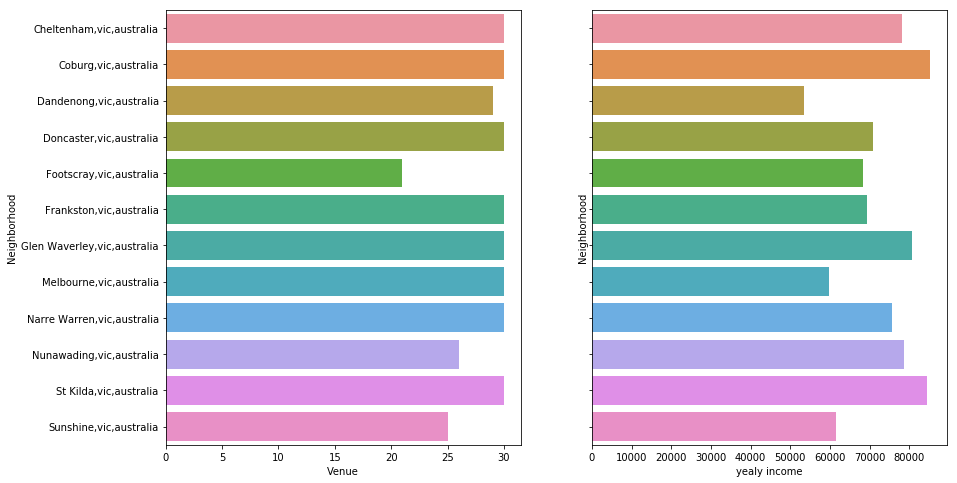

In [40]:
# Two subplots
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(14, 8),sharey=True)

ax1 = sns.barplot(x="Venue", y="Neighborhood", data=clus,ax=ax1)
ax2 = sns.barplot(x="yealy income", y="Neighborhood", data=clus,ax=ax2)

plt.show(ax1,ax2)

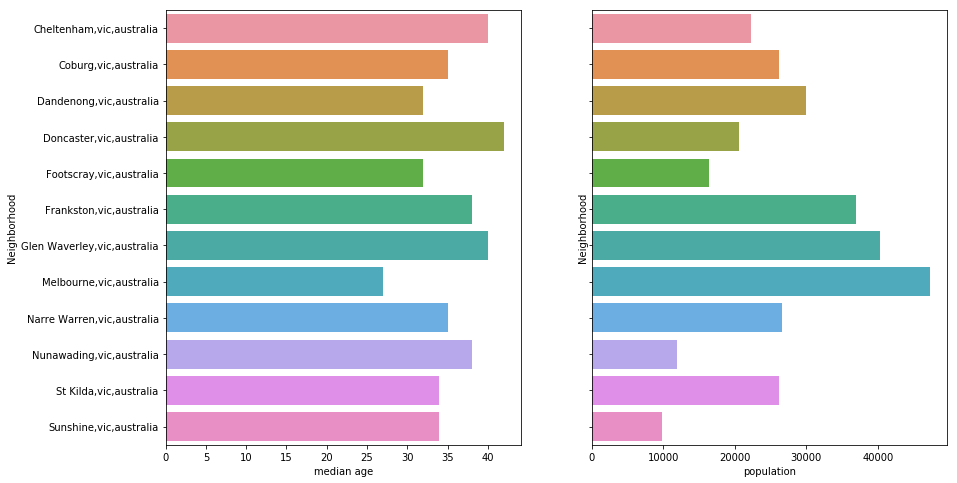

In [41]:
# Two subplots
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(14, 8),sharey=True)

ax1 = sns.barplot(x="median age", y="Neighborhood", data=clus,ax=ax1)
ax2 = sns.barplot(x="population", y="Neighborhood", data=clus,ax=ax2)

plt.show(ax1,ax2)

In [42]:
print(clus.loc[27])


Neighborhood    St Kilda,vic,australia
Latitude                      -37.8638
Longitude                      144.982
population                       26124
median age                          34
yealy income                     84500
Venue                               30
Labels                               1
Name: 27, dtype: object


### Based on its population , number of venues , median age  and close distance to the ocean and attractions we propose St. Kilda for the site of the new bike shop